In [1]:
import numpy as np
import matplotlib.pyplot as plt

import qiskit

from qiskit.ignis.characterization.coherence import T2StarFitter, T2Fitter
from qiskit.ignis.characterization.coherence import t2_circuits, t2star_circuits

In [2]:
from qiskit.tools.jupyter import *
from qiskit import IBMQ
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')

In [3]:
backend = provider.get_backend('ibmq_armonk')

In [11]:
num_of_gates = (np.linspace(10, 800, 50)).astype(int)
gate_time = 0.1

qubit = [0]

#Il T2 circuit è composto da
t2star_circs, t2star_xdata, osc_freq = t2star_circuits(num_of_gates, gate_time, qubit, nosc=5)
t2echo_circs, t2echo_xdata = t2_circuits(np.floor(num_of_gates/2).astype(int), 
                                         gate_time, qubit)
t2cpmg_circs, t2cpmg_xdata = t2_circuits(np.floor(num_of_gates/6).astype(int), 
                                         gate_time, qubit, 
                                         n_echos=5, phase_alt_echo=True)

In [12]:
shots = 500

# Let the simulator simulate the following times for qubits 0 and 2:
t_q0 = 25.0

# Run the qubit
t2star_backend_result = qiskit.execute(t2star_circs, backend, shots=shots).result()
t2echo_backend_result = qiskit.execute(t2echo_circs, backend, shots=shots).result()

# It is possible to split the circuits into multiple jobs and then give the results to the fitter as a list:
t2cpmg_backend_result1 = qiskit.execute(t2cpmg_circs[0:5], backend,
                                        shots=shots).result()
t2cpmg_backend_result2 = qiskit.execute(t2cpmg_circs[5:], backend,
                                        shots=shots).result()

<Figure size 1080x432 with 0 Axes>

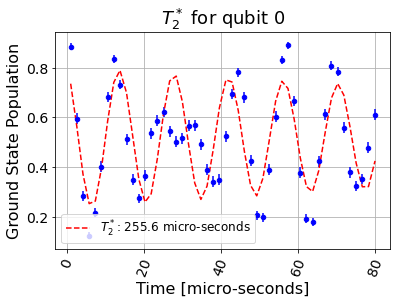

In [16]:
# Fitting T2*

t2star_fit = T2StarFitter(t2star_backend_result, t2star_xdata, qubit,
                          fit_p0=[0.5, t_q0, osc_freq, 0, 0.5],
                          fit_bounds=([-0.5, 20, 0, -np.pi, -0.5],
                                      [1.5, 350, 2*osc_freq, np.pi, 1.5]))

plt.figure(figsize=(15, 6))
t2star_fit.plot(0)
plt.show()

{'0': [array([  0.37562689, 339.58186206,   0.56589936])]}


<Figure size 1080x432 with 0 Axes>

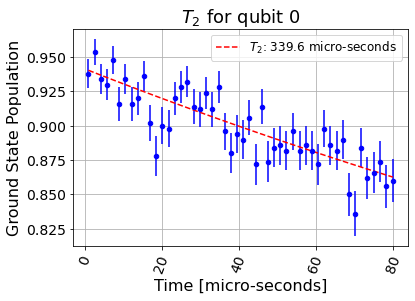

In [18]:
# Fitting T2 single echo

t2echo_fit = T2Fitter(t2echo_backend_result, t2echo_xdata, qubit,
                      fit_p0=[0.5, t_q0, 0.5],
                      fit_bounds=([-0.5, 20, -0.5],
                                  [1.5, 350, 1.5]))

print(t2echo_fit.params)

plt.figure(figsize=(15, 6))
t2echo_fit.plot(0)    
plt.show()

<Figure size 1080x432 with 0 Axes>

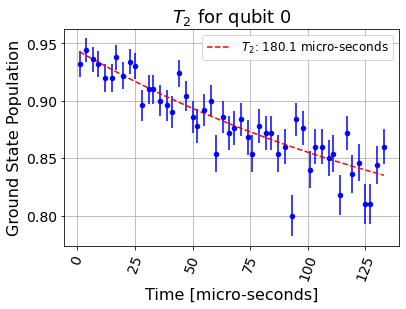

In [19]:
# Fitting T2 CPMG

t2cpmg_fit = T2Fitter([t2cpmg_backend_result1, t2cpmg_backend_result2],
                      t2cpmg_xdata, qubit,
                      fit_p0=[0.5, t_q0, 0.5],
                      fit_bounds=([-0.5, 20, -0.5],
                                  [1.5, 300, 1.5]))

plt.figure(figsize=(15, 6))
t2cpmg_fit.plot(0)
plt.show()